<a href="https://colab.research.google.com/github/yiyixuxu/GeoGuessr-player/blob/main/geoguessr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup

In [4]:
!pip install -q  ml-collections  pytorch_lightning

     |████████████████████████████████| 77 kB 4.0 MB/s 
     |████████████████████████████████| 706 kB 14.6 MB/s 
     |████████████████████████████████| 419 kB 63.2 MB/s 
     |████████████████████████████████| 5.9 MB 50.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [5]:
%%capture
! pip install wandb
import wandb

In [6]:
import random 

## setup project

In [2]:
!git clone https://github.com/yiyixuxu/GeoGuessr-player.git

Cloning into 'GeoGuessr-player'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 0), reused 15 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [3]:
! ls

GeoGuessr-player  sample_data


In [29]:
code_directory = '/content/GeoGuessr-player/GeoGuessr'
editor_relpaths = ('configs/default.py', 'data/country211.py', 'data/base.py')

In [129]:

#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted an any changes are lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will be *persisted*, and even if you re-run the
#@markdown Colab later on, the files will still be the same 

if 'google.colab' in str(get_ipython()):
  import os
  os.chdir('/content')
  mount_gdrive = 'yes' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive')
    code_root_path = f'/content/gdrive/My Drive/{code_directory}'
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    code_root_path = f'/content/{code_directory}'
    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))

  os.chdir(code_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{code_root_path}/{relpath}').read()
    open(f'{code_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{code_root_path}/{relpath}')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
! pwd

/content/gdrive/MyDrive/Github/GeoGuessr-player/GeoGuessr


In [11]:
# import the modules we are going to use 
%load_ext autoreload
%autoreload 2
from configs import default as config_lib
from data.country211 import Country211, Country211_GPS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load config file

if you run the setup project session, you should be able to see a `default.py` file on the right. Note that this configuratin file serves same purpose as command line arguments as show in the FSDL labs. any arguments you would pass to the `run_experiments.py`, you can write it down in this file. 

you can also create different versions of configuration file and use it to initialize your data modules 

In [110]:
config = config_lib.get_config()

In [111]:
config

data:
  batch_size: 32
  data_dir: ./
  dataset: country211
  extensions: null
  gpus: null
  num_workers: null

## create PytorchLightning datamodule

#### the original Country211 dataset (211 country class)

In [165]:
data = Country211(config.data)

In [167]:
# if the data hasn't been download, it will download it for you at this step, may take 20 minutes or so 
# but it will only download once 
data.prepare_data()

In [168]:
data.setup()

In [169]:
# it include 3 datasets 
len(data.data_train), len(data.data_val), len(data.data_test)

(31650, 10550, 21100)

KY


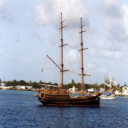

In [170]:
# randomly sample an image and its label from the training set 
idx = random.randint(0, len(data.data_train))
x, y = data.data_train[idx]
print(data.idx_to_class[y])
wandb.Image(x).image

In [171]:
# 3 dataloaders 
train_dl = data.train_dataloader()

In [172]:
batch_x, batch_y = next(iter(train_dl))

In [173]:
batch_x.shape

torch.Size([32, 3, 128, 128])

In [174]:
batch_y

tensor([ 47,  69, 141,  30, 169, 192,  51,  21,  58, 184,  70, 152, 192, 112,
         60, 117,  69,  23, 210, 191, 202,  15, 210, 117, 162, 156,  63, 117,
        177, 131,  94,  33])

#### modified Country211 dataset, where the label is GPS coordinates

you can add a  `target_transform` arguments if you want to create actual label based on the GPS coordinates 

In [125]:
data_gps = Country211_GPS(config.data)

In [126]:
data_gps.prepare_data()
data_gps.setup()

In [127]:
len(data_gps.data_train), len(data_gps.data_val), len(data_gps.data_test)

(31650, 10550, 21100)

('29.302', '48.085833')


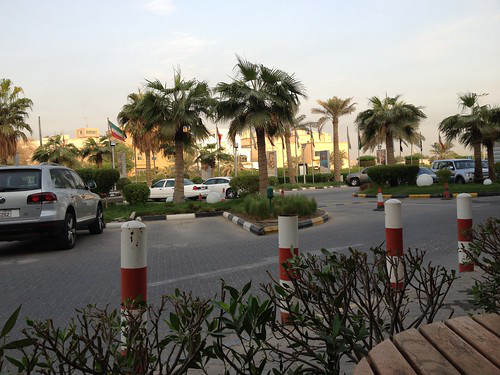

In [128]:
idx = random.randint(0, len(data.data_train))
x, y = data_gps.data_train[idx]
print(y)
x